In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b2
import torchvision.transforms as transforms

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

from tqdm import tqdm
import copy
import os
import shutil

default_path = 'E:/2025_KMITL/CODING/SAIG_AI_2/competition'


In [ ]:
####MOVE UNLABELED IMAGE FROM ALL IMAGE FOLDER TO TEST FOLDER

def move_test_image():
    
    image_path = os.path.join(default_path,'train')
    image_des_path = os.path.join(default_path,'test')
    
    df_uuid = pd.read_csv(os.path.join(default_path, 'sample_submission.csv'))['uuid'] + '.png'
    all_image_file = os.listdir(image_path)
    
    unlabel_file = [i for i in df_uuid if i in all_image_file]
    
    for j in unlabel_file:
        shutil.move(os.path.join(image_path, j), os.path.join(image_des_path, j))
    
    

move_test_image()
    

In [2]:
##CHECK FILE
len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/train')), len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/test'))

(5176, 1411)

In [46]:
def split_valid_train(csv_path):
    
    #FILE THINGS
    train_path = os.path.join(default_path, 'train')
    File = pd.read_csv(os.path.join(default_path, csv_path))
    size = 0.2 #20 persent from train folder
    
    os.makedirs(os.path.join(default_path, 'valid'), exist_ok=True)
    valid_path = os.path.join(default_path, 'valid')
    
    train_df, valid_df = train_test_split(File, test_size=size, stratify=File['style'], random_state=42)
    
    valid_imgs = [v + '.png' for v in valid_df['uuid']]
    
    train_df.to_csv('../train.csv', index=False)
    valid_df.to_csv('../valid.csv', index=False)
    
    for i in tqdm(valid_imgs, desc="Moving valid images"):
        if os.path.exists(os.path.join(train_path, i)):
            shutil.move(os.path.join(train_path, i), os.path.join(valid_path, i))    
        else:
            print('nah')

split_valid_train('train.csv')
              

Moving valid images: 100%|██████████| 1295/1295 [00:00<00:00, 15993.94it/s]

nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah
nah


In [2]:
##CHECK FILE
len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/train')), len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/valid')), len(os.listdir('E:/2025_KMITL/CODING/SAIG_AI_2/competition/test'))

(5176, 1295, 1411)

In [3]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, csv_path, transform=None, has_labels = True):
        self.data_dir = data_dir
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.has_labels = has_labels
        if self.has_labels:
            self.labels_dic = {label : index for index, label in enumerate(sorted(self.df['style'].dropna().unique()))}
            self.labels_dic['UNK'] = 10
        
            
        
    def __len__(self):
        return len(self.df['uuid'])

    def __getitem__(self, idx):
        
        uuid = self.df.loc[idx, 'uuid']
        image_path = os.path.join(self.data_dir, uuid + '.png') #uuid+.png
        image = Image.open(image_path).convert('RGB')
        style = self.df.loc[idx, 'style']
        
        if self.transform:
            image = self.transform(image)
        
        if self.has_labels:
            style = self.df.loc[idx, 'style']
            if pd.isna(style):
                raise ValueError(f"Missing label at index {idx}")
            label = self.labels_dic[style]
    
            return image, label
        else:
            return image
    
    

In [4]:
######################################## TEST ZONE FOR DATASET FUNC #######################
train_dataset = ImageDataset('../train', '../train.csv',has_labels= True)
valid_dataset = ImageDataset('../valid', '../valid.csv',has_labels= True)
test_dataset = ImageDataset('../test', '../sub_dir/submission01.csv', has_labels=False)

7


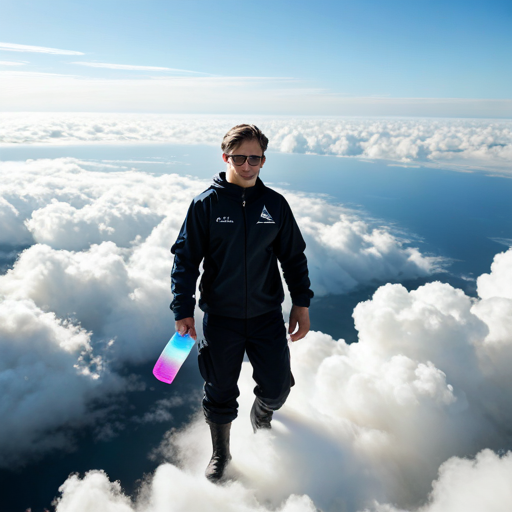

In [5]:
image , label = train_dataset[0]
print(label)
image  

In [6]:

#
means = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform_train = transforms.Compose([transforms.Resize(288),
                                    transforms.CenterCrop(288),
                                    transforms.RandomHorizontalFlip(p = 0.5),
                                    # transforms.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue= 0.02),
                                    transforms.RandomRotation(degrees = 10),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean= means, std=std)])


transform_normal = transforms.Compose([transforms.Resize(288),
                                    transforms.CenterCrop(288),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean= means, std=std)])

train_dataset = ImageDataset('../train', '../train.csv', transform=transform_train, has_labels = True)
valid_dataset = ImageDataset('../valid', '../valid.csv', transform=transform_normal, has_labels = True)
test_dataset = ImageDataset('../test', '../sub_dir/submission01.csv', transform=transform_normal, has_labels = False)


In [7]:
################################ TEST DATASET AFTER TRANSFORM TO TENSOR IMAGE #####################
image, label = train_dataset[0]
print(label)
image

7


tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [8]:
#LOAD DATA STUFF

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#THIS SET FOR TESET

In [9]:
for images, labels in tqdm(train_loader, desc="Loading Train Data"):
    break 

Loading Train Data:   0%|          | 0/162 [00:00<?, ?it/s]


In [10]:
images.shape, labels.shape, labels

(torch.Size([32, 3, 288, 288]),
 torch.Size([32]),
 tensor([9, 8, 6, 7, 3, 5, 9, 9, 7, 9, 5, 9, 0, 8, 6, 3, 0, 0, 5, 3, 5, 8, 8, 8,
         6, 3, 0, 5, 9, 3, 4, 0]))

SET UP FOR TRAING LOOP

In [11]:
model = efficientnet_b2(weights='DEFAULT')
# model.classifier[1] =nn.Linear(in_features=512, out_features=11)
model.classifier[1] = nn.Linear(in_features=1408, out_features=11)
print(str(model))


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
####### CHECK ##########
######## IMAGE FORM DATALOADER ######
example = model(images)
example.shape

torch.Size([32, 11])

###### ###### TRAINING LOOP ###### ###### ❤️❤️❤️❤️❤️❤️❤️❤️❤️ SAIG ❤️❤️❤️❤️❤️❤️

MOBILENET_V2
##epcoh =5 ##
##Epoch 5/5 - Train loss: 0.3678677924861575, Validation loss: 0.47692899825950386##

NEST ซักอย่าง ลืม

In [13]:
##################### CHECK CUDA IN DEVICE ################3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [15]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [28]:
# training loop 
num_epochs = 5
early_stopping = EarlyStopping(patience=2)
best_model_wts = copy.deepcopy(model.state_dict())
train_losses, val_losses = [], []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    
    #for man mai dee kin 
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}, F1 Score: {val_f1}")
    
    if val_loss < early_stopping.best_loss:
        best_model_wts = copy.deepcopy(model.state_dict())
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping!")
        break

Validation loop: 100%|██████████| 41/41 [00:26<00:00,  1.52it/s]


Epoch 1/5 - Train loss: 0.5498843273202639, Validation loss: 0.7110880947481251, F1 Score: 0.9178773955710918


Validation loop: 100%|██████████| 41/41 [00:23<00:00,  1.74it/s]


Epoch 2/5 - Train loss: 0.5366295272084255, Validation loss: 0.6983472015866902, F1 Score: 0.9095324992195966


Validation loop: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 3/5 - Train loss: 0.5308117814926313, Validation loss: 0.7008955084679209, F1 Score: 0.9164940217265887


Validation loop: 100%|██████████| 41/41 [00:26<00:00,  1.54it/s]

Epoch 4/5 - Train loss: 0.5297745815384701, Validation loss: 0.6998535394208312, F1 Score: 0.920741126396481
Early stopping!


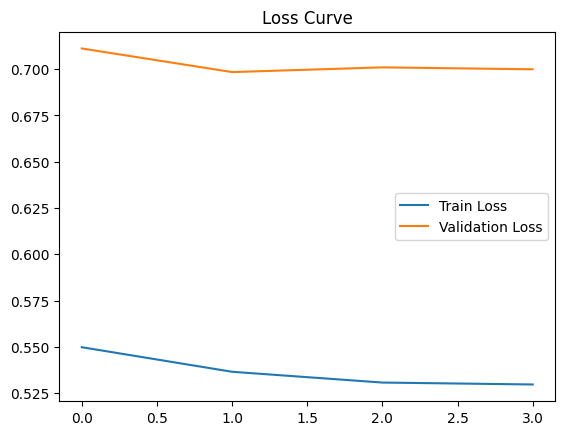

In [29]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

In [30]:
torch.save(model.state_dict(), '2_efficientnet_b2.pth')

In [31]:
def predict_with_threshold(model, dataloader, threshold=0.6, unk_class_index=10):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Predicting"):
            if isinstance(images, (list, tuple)):
                images = images[0]  # กรณี dataloader ส่ง (image, label)
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            confs, preds = torch.max(probs, dim=1)
            for conf, pred in zip(confs, preds):
                if conf.item() < threshold:
                    predictions.append(unk_class_index)  
                else:
                    predictions.append(pred.item())      
    return predictions

In [34]:
preds = predict_with_threshold(model, test_loader, threshold=0.7, unk_class_index=10)

Predicting: 100%|██████████| 45/45 [00:28<00:00,  1.57it/s]


In [35]:
unknown_count = sum(1 for label in preds if label == 10)
print(unknown_count)

113


In [39]:
df = pd.read_csv("../sub_dir/submission01.csv") 
df["style"] = preds
df.to_csv("../sub_dir/submission04_b2_1.csv", index=False)

lowpoly


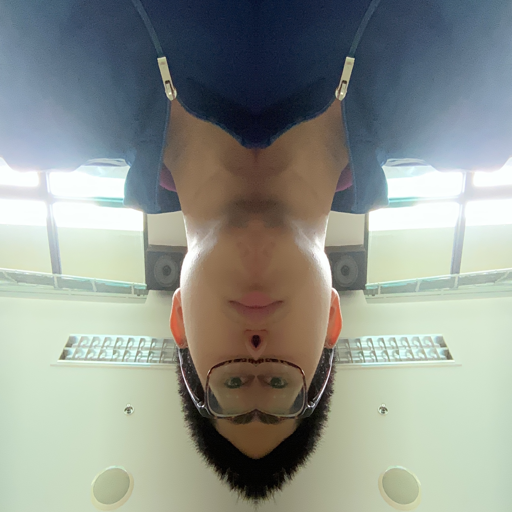

In [40]:

my_dict = {0: 'Ink scenery',
           1: 'comic',
           2: 'cyberpunk',
           3: 'futuristic UI',
           4: 'lowpoly',
           5: 'oil painting',
           6: 'pixel',
           7: 'realistic',
           8: 'steampunk',
           9: 'water color',
           10: 'UNK'}

def checktest(idx, img_dir, csv_path, dict):
    df_read = pd.read_csv(csv_path)
    uuid = df_read.loc[idx, 'uuid']
    img_path = os.path.join(img_dir, uuid + '.png')
    img = Image.open(img_path).convert('RGB')
    style = dict[df_read.loc[idx, 'style']]
    return img, style
    
img, label = checktest(1410, '../test', '../sub_dir/submission04_b2_1.csv', my_dict)
print(label)
img

In [27]:
def label_to_style(csvfile):
    df = pd.read_csv(csvfile)
    df['style'] = df['style'].map(my_dict)
    Name = csvfile
    df.to_csv(Name, index=False)

label_to_style('../sub_dir/submission04_b2.csv')